# The Evaporating Inventory Incident

You have been contracted for your first investigation. The [COO](https://en.wikipedia.org/wiki/Chief_operating_officer) of a company has heard rumors about irregularities in the inventory. Nothing specific but enough to get her curious. 

You have requested a copy of the data from the company's SAP system. You focus on the **material documents**. 

Your objective is to analyze the data to identify and understand the irregularities. **Can you establish sufficient evidence for fraud?**

## Setup

Some initialization to make life easier. **Make sure to run the following cell before proceeding.**

In [55]:
#Allow multiple outputs for each cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
#Show simple plots in the notebook
import matplotlib.pyplot as plt
%matplotlib inline

We use the following libraries:
* [Pandas](https://pandas.pydata.org) is the most important workhorse in data analytics.
* [Altair](https://altair-viz.github.io) is a visualization library.

In [56]:
import pandas as pd
import altair as alt
from altair import *
import numpy as np
#Format number without any decimals
pd.set_option('display.float_format', lambda x: '%.4f' % x)
#Show altair plots in the notebook
alt.renderers.enable('notebook')

You have received two tables from the SAP system, which contain the information of the **material movements** in the company:
2. The header information of the material documents are stored in the table `MKPF`.
1. The line item information of the material documents is stored in the table `MSEG`.

In [57]:
mkpf_table = pd.read_csv('https://raw.githubusercontent.com/mschermann/forensic_accounting/master/MKPK_EI.csv')
mseg_table = pd.read_csv('https://raw.githubusercontent.com/mschermann/forensic_accounting/master/MSEG_EI.csv',low_memory=False)

## Understanding the tables

### The MKPF table

For our purposes, we use the following columns from `MKPF`:
* `MBLNR` - Contains the material document number.
* `USNAM` - Contains the inventory employee who posted the material document.

### The MSEG table

For our purposes, we use the following columns from `MSEG`:
* `MBLNR` - Contains the material document number.
* `BWART` - Contains the movement type of the line item. This [link](https://wiki.scn.sap.com/wiki/display/ERPLO/Movement+types) contains information about the movement types.
* `MATNR` - Contains the material id of the material moved.
* `LGORT` - Contains the storage location.
* `DMBTR` - Contains the value of the material movement.
* `MENGE` - Contains the volume of the movement in units of the material. 

## Understanding the company

After a meeting you understand that the company has four locations:
* `DL00` - the factory in Dallas, TX
* `MI00` - the factory in Miami, FL
* `SD00` - the factory in San Diego, CA
* `SC00` - the factory in Santa Clara, CA

Furthermore, the company has the following **groups** of raw materials in its storage locations (`RM00`) across the locations in the company code `US00`. You keep a record of the groups in the following variables.

**Marvelous Materials:**
* `ADAMANTIUM`
* `CARBONITE`
* `KRYPTONITE`

In [58]:
marvel = ['ADAMANTIUM', 'CARBONITE', 'KRYPTONITE']

**Boring Metals:**
* `GOLD` 
* `IRON`
* `PALLADIUM`
* `SILVER`

In [59]:
boring = ['GOLD', 'IRON', 'PALLADIUM', 'SILVER']

**Gems:**
* `ANGOLAN AMETHYST`
* `AUSTRALIAN AMETHYST`
* `BOTSWANA BLACK PE`
* `BRITAIN BLACK PEAR`
* `CANADIAN CRYSTAL`
* `CONGOCRYSTAL`
* `DIAMOND`
* `ROMANIAN RUBY`
* `RUBY`
* `RUSSIAN RUBY`
* `SA SAPPHIRE`
* `SWISS SAPPHIRE`

In [60]:
gems = ['ANGOLAN AMETHYST','AUSTRALIAN AMETHYST', 'BOTSWANA BLACK PE',\
        'BRITAIN BLACK PEAR', 'CANADIAN CRYSTAL', 'CONGOCRYSTAL', \
        'DIAMOND', 'ROMANIAN RUBY', 'RUBY', \
        'RUSSIAN RUBY', 'SA SAPPHIRE','SWISS SAPPHIRE']

**Essentials:**
* `CHRONIUM`
* `CONCRETE`
* `ICAN HEADMASK`
* `MAGICDUST`
* `ORANGE`
* `PAPER`
* `ROSE ESSENTIAL OIL`
* `TEST`
* `WALLET`

In [61]:
essentials = ['CHRONIUM', 'CONCRETE',  'ICAN HEADMASK', \
              'MAGICDUST', 'ORANGE',  'PAPER', \
              'ROSE ESSENTIAL OIL',  'TEST', 'WALLET']

**Consumables:**
* `AAA LUBE` 
* `BLUEPAINT`
* `BOLT1000`
* `HEXNT`
* `LIQUID`
* `ZTESTHEXNT`

In [62]:
consumables = ['AAA LUBE', 'BLUEPAINT', 'BOLT1000', \
               'HEXNT','LIQUID','ZTESTHEXNT']

## Your investigation

### Reduce the tables to the relevant columns

**Your objective:** Focus on the columns that are important to your investigation.

In [63]:
mseg = mseg_table.loc[:,['MBLNR','BWART','MATNR','WERKS','LGORT','DMBTR','MENGE']]

In [64]:
mkpf = mkpf_table.loc[:,['MBLNR', 'USNAM']]

In [65]:
mseg = pd.merge(mseg, mkpf, how='left', on='MBLNR')

### Include the material group information to the `MATNR` column

In [66]:
mseg['GROUP'] = 'MARVEL'
mseg.loc[mseg['MATNR'].isin(boring), 'GROUP'] = 'BORING'
mseg.loc[mseg['MATNR'].isin(gems), 'GROUP'] = 'GEMS'
mseg.loc[mseg['MATNR'].isin(essentials), 'GROUP'] = 'ESSENTIALS'
mseg.loc[mseg['MATNR'].isin(consumables), 'GROUP'] = 'CONSUMABLES'

### Develop an overview of the material movements

**Your objective:** Identify potential irregularities in the material movement data.

Think along the following lines:

* What are the differences between the locations?
* What are the differences between the movement types?
* What are the relationships between the movement types?

**Please note**: You cannot have numbers as column headers.

In [67]:
mseg['BWART'] = mseg['BWART'].map({101: 'GR', 261: 'GI', 333: 'SA', 551: 'SC'})

In [68]:
mseg_pivot = mseg.pivot_table(index=['WERKS','GROUP'], columns='BWART', values='MENGE', aggfunc='sum').reset_index()

In [69]:
mseg_pivot['utilization'] = mseg_pivot['GI'] / mseg_pivot['GR']
mseg_pivot['scrapping'] = mseg_pivot['SC'] / mseg_pivot['GR']
mseg_pivot['sampling'] = mseg_pivot['SA'] / mseg_pivot['GR']

In [70]:
h = mseg_pivot.groupby(['WERKS', 'GROUP'])\
[['utilization', 'scrapping', 'sampling']].mean().reset_index().\
sort_values('sampling', ascending=False)

In [71]:
h = mseg_pivot.groupby(['WERKS', 'GROUP'])\
[['utilization', 'scrapping', 'sampling']].mean().reset_index()

In [72]:
h

BWART,WERKS,GROUP,utilization,scrapping,sampling
0,DL00,BORING,0.8840,0.0278,0.0159
1,DL00,CONSUMABLES,0.8820,0.0140,0.0246
2,DL00,ESSENTIALS,0.8845,0.0232,0.0219
3,DL00,GEMS,0.9039,0.0155,0.0221
4,DL00,MARVEL,0.8920,0.0095,0.0100
5,MI00,BORING,0.9127,0.0102,0.0159
6,MI00,CONSUMABLES,0.9217,0.0284,0.0196
7,MI00,ESSENTIALS,0.9146,0.0286,0.0163
8,MI00,GEMS,0.9225,0.0108,0.0130
9,MI00,MARVEL,0.9118,0.0411,0.0097


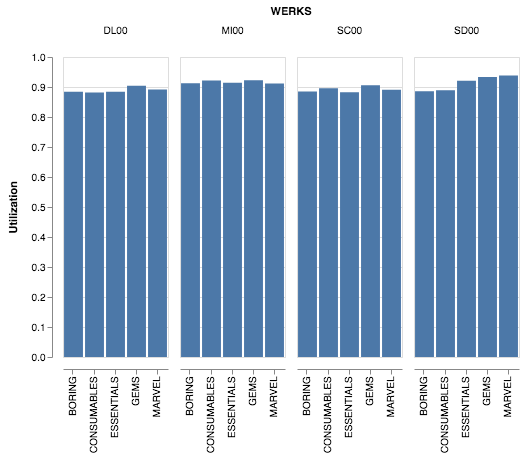

In [73]:
util = alt.Chart(h).mark_bar(stroke='transparent').encode(
    x=alt.X('GROUP', axis=alt.Axis(title='')),
    y=alt.Y('utilization', scale=alt.Scale(domain=(0, 1)), axis=alt.Axis(title='Utilization')),
    column='WERKS'
)
util

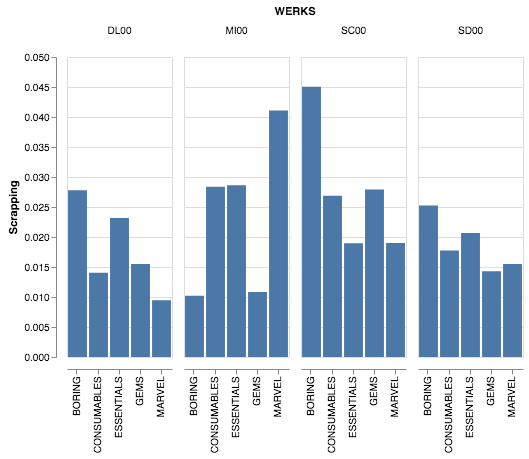

In [74]:
scrap = alt.Chart(h).mark_bar(stroke='transparent').encode(
    x=alt.X('GROUP', axis=alt.Axis(title='')),
    y=alt.Y('scrapping', scale=alt.Scale(domain=(0, .05)), axis=alt.Axis(title='Scrapping')),
    column='WERKS'
)

scrap

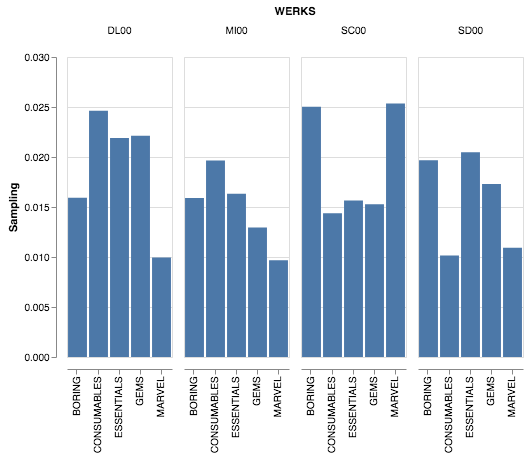

In [75]:
sample = alt.Chart(h).mark_bar(stroke='transparent').encode(
    x=alt.X('GROUP', axis=alt.Axis(title='')),
    y=alt.Y('sampling', scale=alt.Scale(domain=(0, .03)), axis=alt.Axis(title='Sampling')),
    column='WERKS'
)

sample

## What is the fraud?

In [76]:
g = mseg.groupby(['WERKS','GROUP','BWART']).agg({'MENGE':'sum','USNAM':'unique'}).reset_index()

In [77]:
g['USNAM_NO'] = g['USNAM'].apply(lambda x: len(x))

In [78]:
g[g['USNAM_NO']<3]

,WERKS,GROUP,BWART,MENGE,USNAM,USNAM_NO
58,SC00,MARVEL,SA,20929,[GBI-073],1


**Reflect:** Can you explain the fraud?